# Kanapy
## Example: Analysis of EBSD maps and generation of voxelated RVE

Author: Alexander Hartmaier<br>ICAMS, Ruhr University Bochum, Germany<br>
June 2022

### 1. Prepare system settings

In [1]:
import kanapy as knpy
from math import pi

if not knpy.MTEX_AVAIL:
    raise ModuleNotFoundError('Anaysis of EBSD maps is only possible with an '+\
                              'existing MTEX installation in Matlab.')

### 2. Analyse EBSD map with MTEX module and obtain statistical information

I found another version of MTEX and remove it from the current search path!
initialize MTEX 5.5.2  ....Warning: "/Users/alexander/Codes/kanapy/libs/mtex/extern/nfft_openMP" not found in path.
> In rmpath (line 71)
In check_installation (line 7)
In startup_mtex (line 79)
In startup (line 9)

********************************************************************************
 
  MTEX: Error running NFFT!
   
  The original error message was:
  Undefined function 'nfsftmex' for input arguments of type 'char'.
 
 I did not get NFFT working. This restricts the functionality of MTEX.
 To overcome this restriction you may need to compile the NFFT your own.
 Please have a look at https://mtex-toolbox.github.io/installation for possible workarounds

********************************************************************************
 done!
 
 For compatibility reasons MTEX is not using OpenMP.
 You may want to switch on OpenMP in the file <a href="matlab: edit mtex_settings">mtex_settings.m</a>
 

 eb

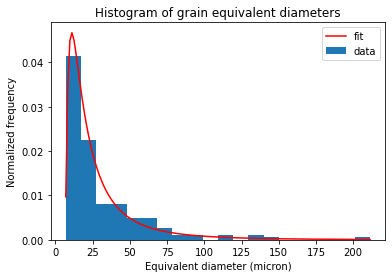

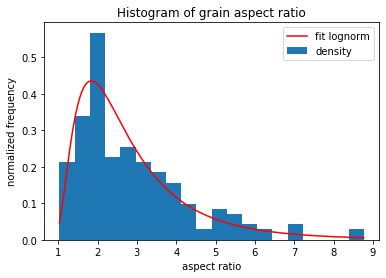

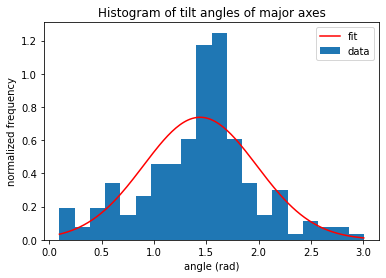

Analyzed microstructure with 182 grains.
Average grain size = 14.123 micron, average aspect ratio = 1.69,         average tilt angle = 82.551°


In [2]:
fname = 'ebsd_316L_500x500.ang'  # name of ang file to be imported
matname = 'Iron fcc'  # material name for MTEX
matnumber = 4         # material number of austenite in CP UMAT

# read EBSD map and evaluate statistics of microstructural features
ebsd = knpy.EBSDmap(fname, matname)


### 3. Pack ellipsoids and generate voxelized RVE

Generating particle distribution based on user defined statistics


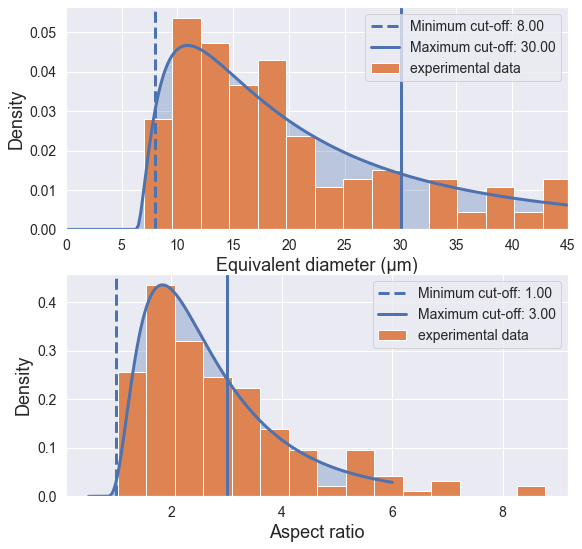

Creating an RVE based on user defined statistics
    Total number of grains        = 39
    RVE side lengths (X, Y, Z)    = 60, 60, 60
    Number of voxels (X, Y, Z)    = 25, 25, 25
    Voxel resolution (X, Y, Z)    = 2.4000, 2.4000, 2.4000
    Total number of voxels (C3D8) = 15625

Starting particle simulation
    Creating simulation box of required dimensions
    Creating particles from distribution statistics
    Particle packing by growth simulation


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1001/1001 [03:39<00:00,  4.56it/s]


Completed particle packing
32 overlapping particles detected after packing
Kinetic energy of particles after packing: 10.939820623037726
Initial kinetic energy: 9.403352624263086



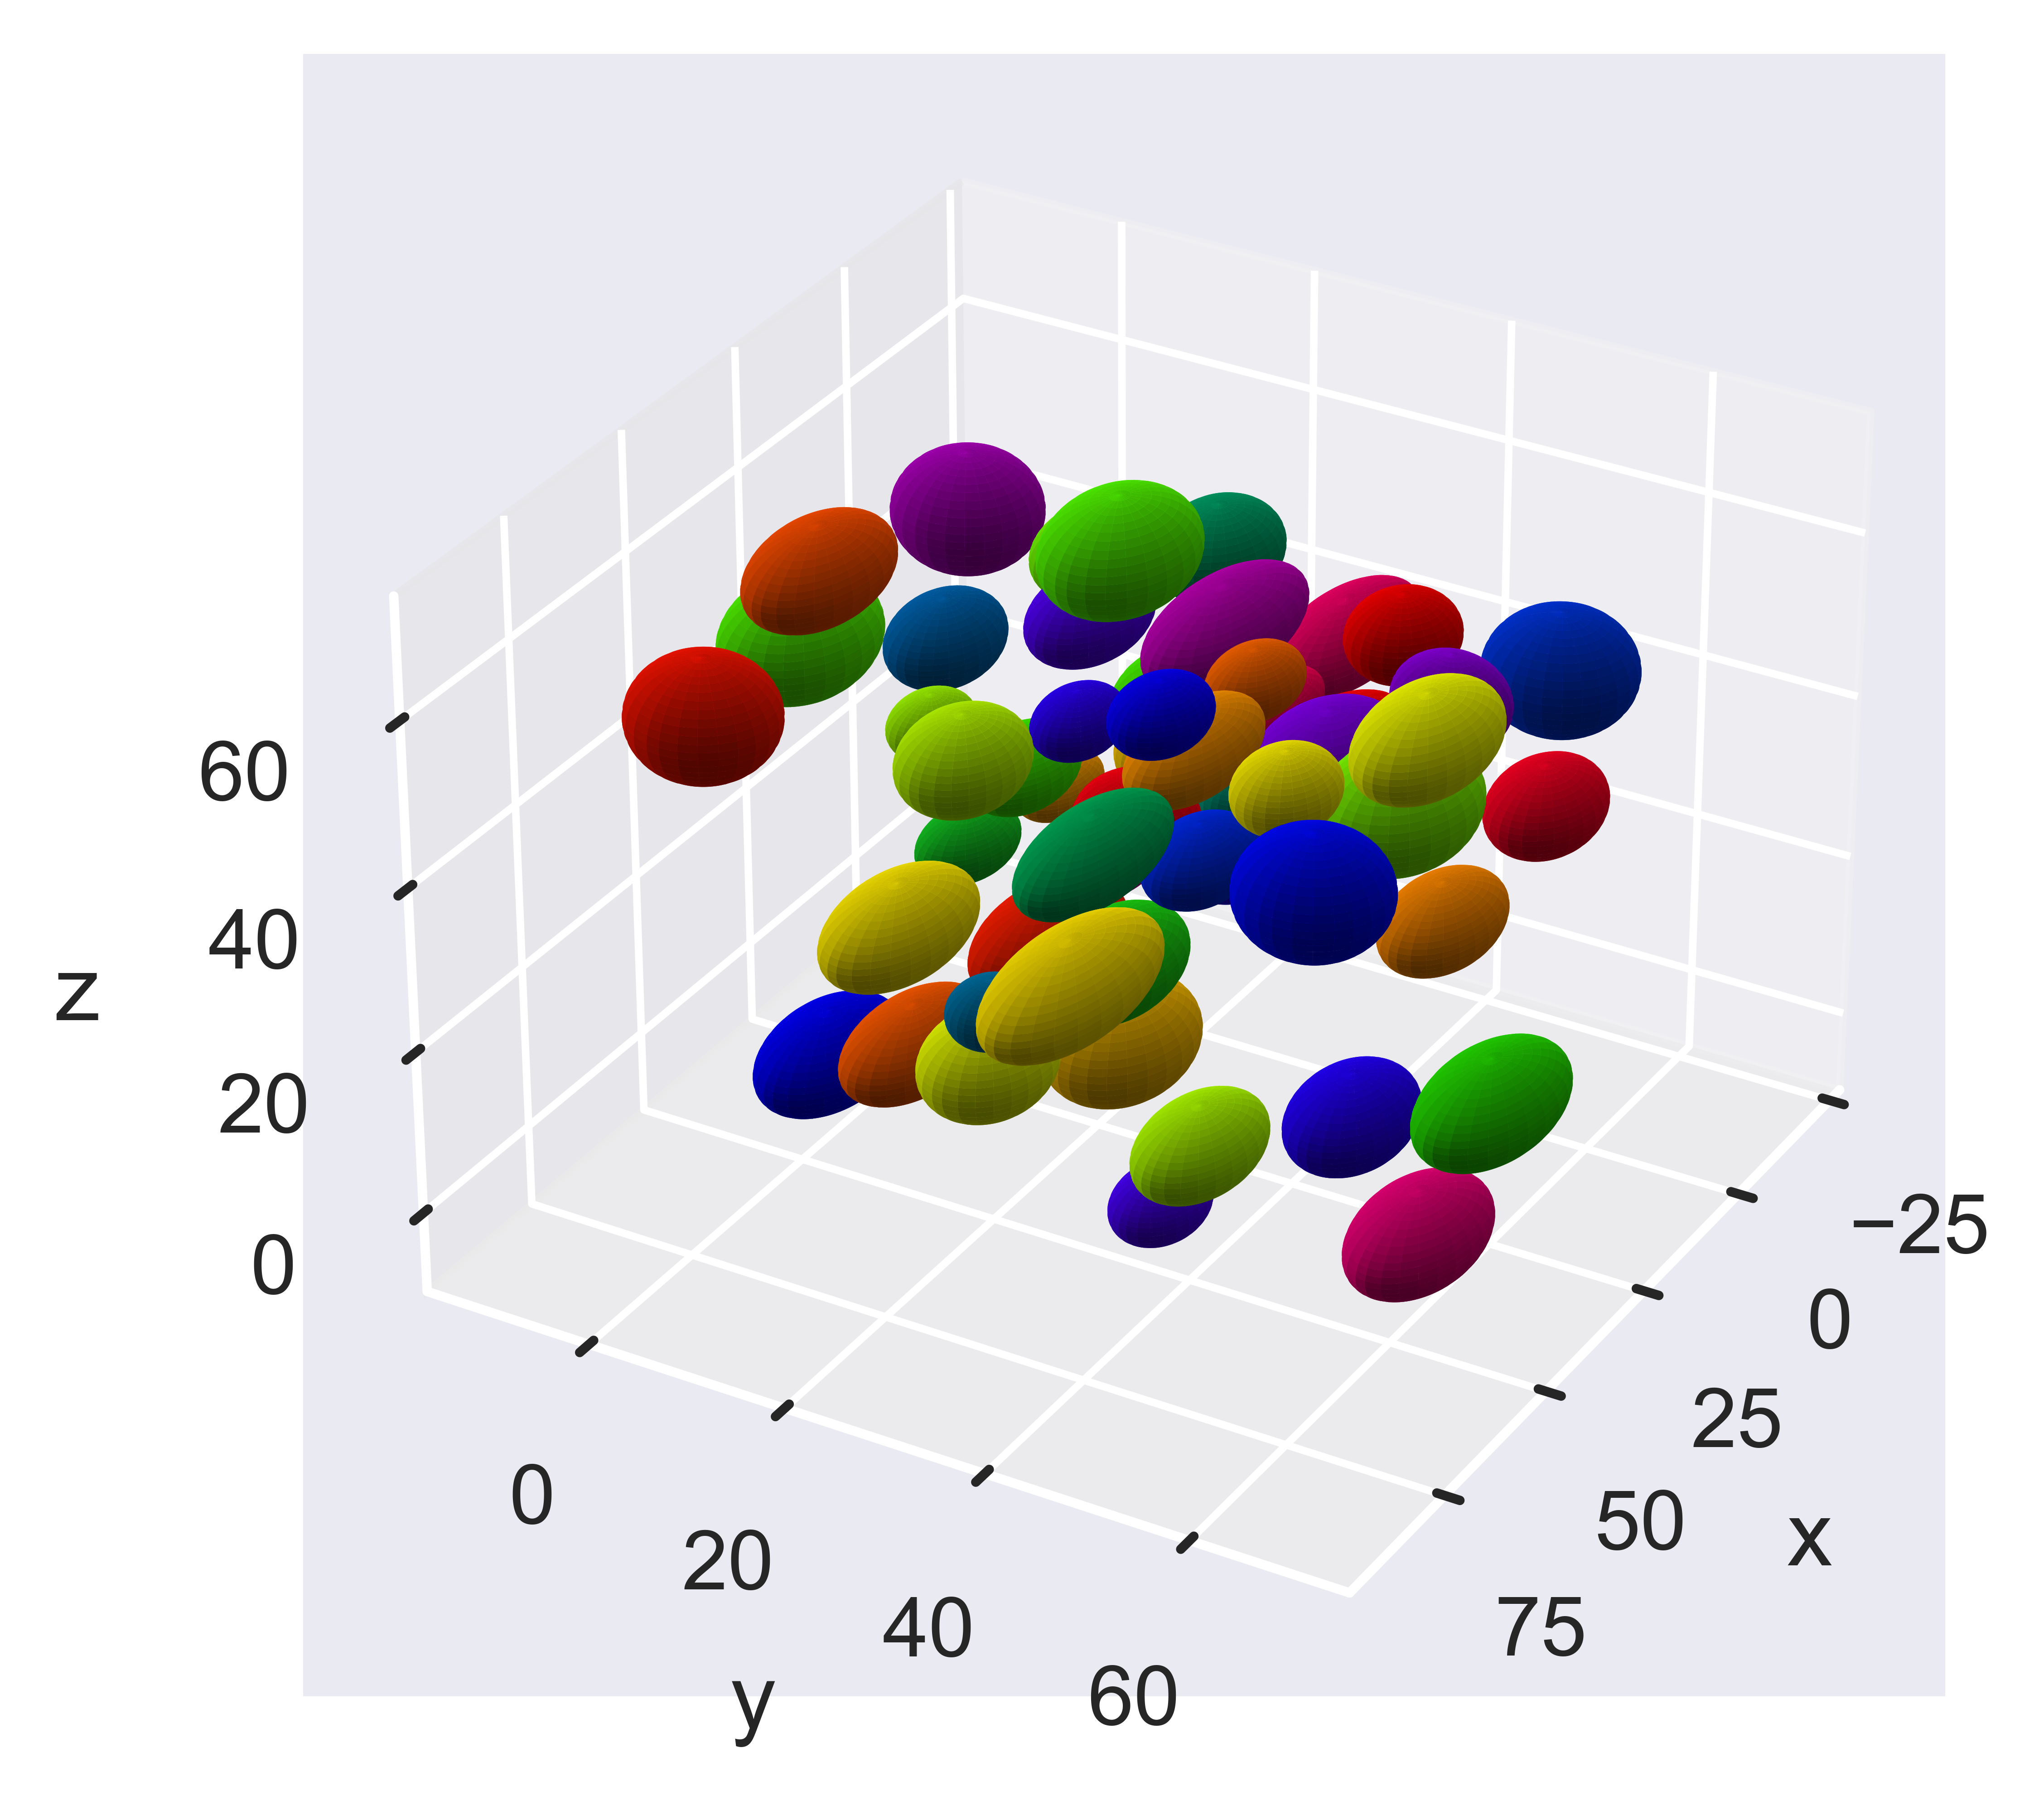


Starting RVE voxelization
    Generating voxels inside RVE
### create voxels 17576 (17576, 3)
    Assigning voxels to grains


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15625/15625 [00:00<00:00, 14115011.85it/s]


Completed RVE voxelization


Computing the L1-error between input and output diameter distributions
    L1 error between particle and grain geometries: 1.17949

Plotting input & output statistics


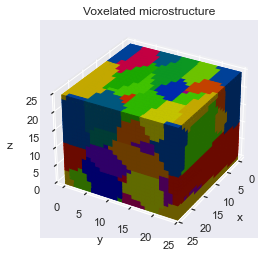

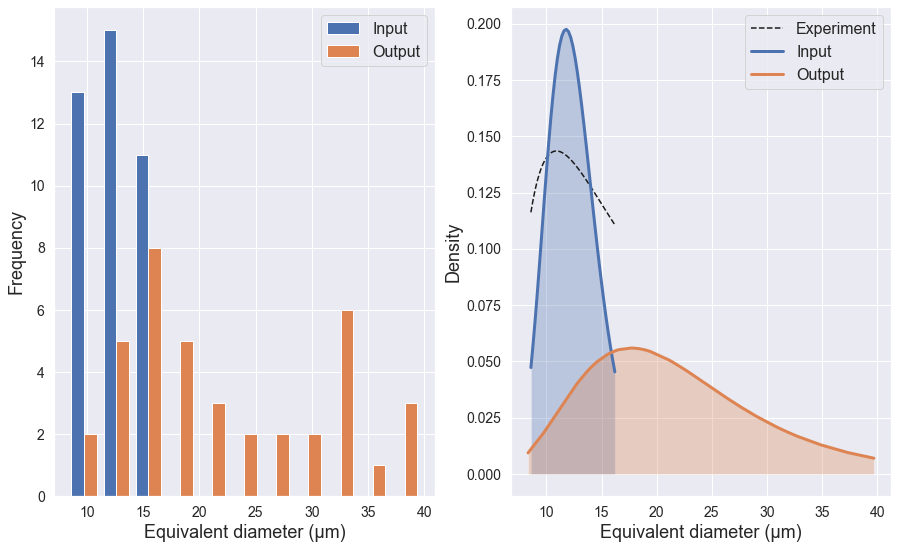

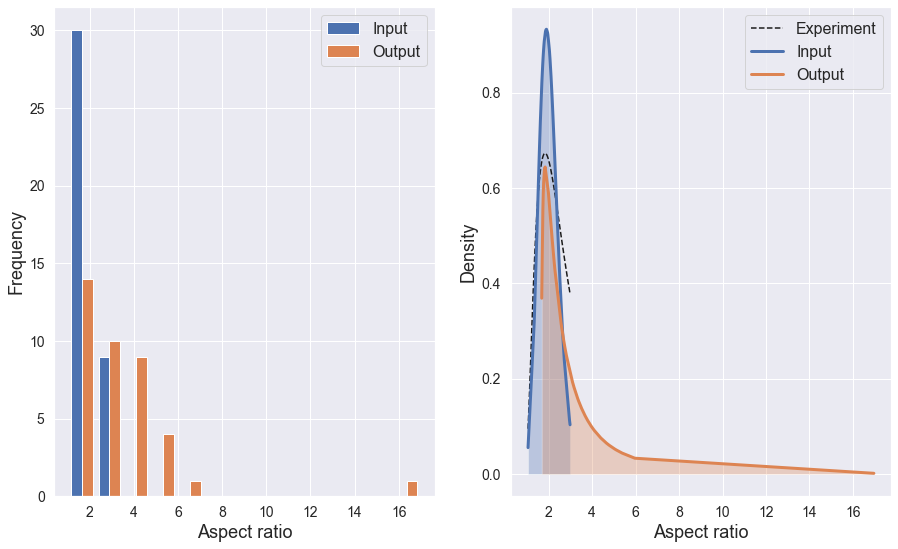

---->DONE!



In [3]:
# create dictionary with statistical information obtained from EBSD map
# gs_param : [std deviation, mean grain size, offset of lognorm distrib.]
# ar_param : [std deviation, mean aspect ration, offset of gamma distrib.]
# om_param : [std deviation, mean tilt angle]
Nv = 25
size = 60
periodic = True
ms_stats = knpy.set_stats(ebsd.gs_param, ebsd.ar_param, ebsd.om_param,
                          deq_min=8., deq_max=30., asp_min=1., asp_max=3.,
                          omega_min=0., omega_max=2*pi, voxels=Nv, size=size,
                          periodicity=periodic, VF = 1.0, phasename = "XXXX", phasenum = 0)

# create and visualize synthetic RVE
ms = knpy.Microstructure(descriptor=ms_stats, name=fname+'_RVE')
ms.init_stats(gs_data=ebsd.gs_data, ar_data=ebsd.ar_data)
ms.init_RVE()
ms.pack()
ms.plot_ellipsoids()
ms.voxelize()
ms.plot_voxels(sliced=False)
ms.analyze_RVE()
ms.plot_stats(gs_param=ebsd.gs_param, ar_param=ebsd.ar_param)


In [4]:
# get list of orientations for grains in RVE matching the ODF of the EBSD map
ori_rve = ebsd.calcORI(ms.Ngr, ms.shared_area)

# write Abaqus input file for voxelated structure
ptag = 'pbc' if periodic else 'non-pbc'
ms.output_abq('v', name=f'from_ebsd_vox{Nv}_gr{ms.Ngr}_{ptag}.inp')
# write Euler angles of grains into Abaqus input file
knpy.writeAbaqusMat(matnumber, ori_rve)
!mv Material.inp 'from_ebsd_mat{matnumber}_gr{ms.Ngr}.inp'

Optimum kernel estimated from mean orientations of grains
 estimating optimal kernel halfwidth: 0%
 estimate optimal kernel halfwidth: 10%
 estimate optimal kernel halfwidth: 20%
 estimate optimal kernel halfwidth: 30%
 estimate optimal kernel halfwidth: 40%
 estimate optimal kernel halfwidth: 50%
 estimate optimal kernel halfwidth: 60%
 estimate optimal kernel halfwidth: 70%
 estimate optimal kernel halfwidth: 80%
 estimate optimal kernel halfwidth: 90%
 estimate optimal kernel halfwidth: 100%

time =

   26.6258


e =

    0.2580


e =

    0.2559


e =

    0.2523


e =

    0.2435


e =

    0.2401


e =

    0.1971


e =

    0.1955


e =

    0.1707


e =

    0.1658


e =

    0.1517


e =

    0.1503


e =

    0.1497


e =

    0.1242


e =

    0.1224


e =

    0.1057


e =

    0.1035


e =

    0.1005


e =

    0.0997


e =

    0.0985


e =

    0.0963


e =

    0.0959


e =

    0.0920


e =

    0.0877


e =

    0.0695


e =

    0.0659


e =

    0.0646


e =

    

![test](./IPFkey.png)